<a href="https://colab.research.google.com/github/KimBbaoro/kebTeamProject/blob/master/slowfast_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install pytorchvideo
!pip install transformers


  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-075gwie0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-075gwie0
  Resolved https://github.com/facebookresearch/fvcore.git to commit 0f2b23b6f93e36041d9a74764ee824541cf0a0e5
  Preparing metadata (setup.py) ... done


In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import albumentations as A
import torchvision.transforms as transforms
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
import torchvision
import torch.nn as nn
from sklearn.metrics import f1_score,accuracy_score

from transformers.optimization import AdamW


from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정
from pytorchvideo.transforms import Normalize

# CFG = {
#     "VIDEO_LENGTH":
# }



In [ ]:
train = pd.read_csv("/content/drive/MyDrive/data/train_test.csv",index_col=0)
valid = pd.read_csv("/content/drive/MyDrive/data/valid_test.csv",index_col=0)
test = pd.read_csv("/content/drive/MyDrive/data/test_test.csv",index_col=0)



In [ ]:
valid["video_name"]

659     /content/drive/MyDrive/data/abnormal/파손/C_3...
1982    /content/drive/MyDrive/data/abnormal/절도/C_3...
2627    /content/drive/MyDrive/data/normal/시험/C_2_3...
600     /content/drive/MyDrive/data/abnormal/파손/C_3...
2239    /content/drive/MyDrive/data/normal/구매/C_2_4_...
                              ...                        
2520    /content/drive/MyDrive/data/normal/반품/C_2_...
2453    /content/drive/MyDrive/data/normal/반품/C_2_...
1016    /content/drive/MyDrive/data/abnormal/폭행/C_...
830     /content/drive/MyDrive/data/abnormal/폭행/C_...
1531    /content/drive/MyDrive/data/abnormal/절도/C_3...
Name: video_name, Length: 288, dtype: object

In [ ]:
train = train[~train['video_name'].str.contains('Store')]
valid = valid[~valid['video_name'].str.contains('Store')]
test = test[~test['video_name'].str.contains('Store')]

In [ ]:
cls = ["class_0", "class_1", "class_2","class_3"]
print(train[cls].sum().sum())
train.info()


2308
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2308 entries, 471 to 933
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_name  2308 non-null   object
 1   tag         2308 non-null   int64 
 2   class_0     2308 non-null   int64 
 3   class_1     2308 non-null   int64 
 4   class_2     2308 non-null   int64 
 5   class_3     2308 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 126.2+ KB


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
mean = (0.45, 0.45, 0.45)
std = (0.225,0.225, 0.225)

class CustomDataset(Dataset):
  def __init__(self, video_path_list,label_list, tfms=None):
    self.video_path_list = video_path_list
    self.label_list = label_list
    self.norm = Normalize(mean, std)
    self.tfms = tfms

  def __getitem__(self, index):
    try:
      frames = self.get_video(self.video_path_list[index])[:,2:,:,:]
      low_frames = frames[:,[i*4 for i in range(19)],:,:] #19

      if self.label_list is not None:
        label = self.label_list[index]
        return low_frames, frames, label #프레임 적고/크고
      else:
        return low_frames, frames #slow, fast #이 부분을 없애야 하나.

    except Exception as e:
      print(f"An exception occurred in get_video function: {e}")
      return None


  def __len__(self):
    return len(self.video_path_list)

  def get_video(self, path):
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(77): #77
      _, img = cap.read()

      if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256))
        img = img/255
        frames.append(img)

    cap.release()
    if self.tfms is not None:
      frames = aug_video(frames, tfms=self.tfms)

    return self.norm(torch.FloatTensor(np.array(frames)).permute(3,0,1,2))

def aug_video(vid, tfms):
    aug_vid = []
    for x in vid:
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

tfms = A.Compose([
            A.HorizontalFlip(p=0.5)
            ], p=1)




In [ ]:
train_dataset = CustomDataset(train["video_name"].values, train["tag"].values,tfms=tfms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

val_dataset = CustomDataset(valid["video_name"].values, valid["tag"].values)
val_loader = DataLoader(val_dataset, batch_size =4, shuffle=False, num_workers=0)

In [ ]:
backbone = torch.hub.load("facebookresearch/pytorchvideo", model="slowfast_r50",pretrained=True)


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [ ]:
model_name = "slowfast_r50"
slowfast_r50 = torch.hub.load("facebookresearch/pytorchvideo", model=model_name,pretrained=True)
slowfast_r50_layers = slowfast_r50.blocks

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [ ]:
class SlowFast(nn.Module):
    def __init__(self,img_size=256):
        super(SlowFast, self).__init__()
        self.pool_size = img_size//32-1

        self.layer_1 = slowfast_r50_layers[0]
        self.layer_2 = slowfast_r50_layers[1]
        self.layer_3 = slowfast_r50_layers[2]
        self.layer_4 = slowfast_r50_layers[3]
        self.layer_5 = slowfast_r50_layers[4]
        self.fast_pool = nn.AvgPool3d(kernel_size=(19, self.pool_size, self.pool_size), stride=(1, 1, 1), padding=(0, 0, 0))
        self.slow_pool = nn.AvgPool3d(kernel_size=(75, self.pool_size, self.pool_size), stride=(1, 1, 1), padding=(0, 0, 0))

        self.avgpool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(2304,4)

        for para in self.layer_1.parameters():
           para.requires_grad = False
        for para in self.layer_2.parameters():
           para.requires_grad = False

    def forward(self, x):
        # print("flag1")
        batch_size = x[0].size(0)
        # print("flag2")

        x = self.layer_1(x)
        # print("flag3")

        x = self.layer_2(x)
        # print("flag4")

        x = self.layer_3(x)
        # print("flag5")

        x = self.layer_4(x)
        # print("flag6")

        x = self.layer_5(x)
        # print("flag7")

        # print("x[0] : ",x[0].shape)
        # print("x[1] : ",x[1].shape)



        x_1 = self.fast_pool(x[0])
        #print("flag8")

        x_2 = self.slow_pool(x[1])
        #print("flag9")
        # print("x_1 : ", x_1.shape)
        # print("x_2 : ", x_2.shape)

        x = torch.concat([x_1,x_2],axis=1)
        #print("flag10")

        x = self.avgpool(x).view(batch_size,-1)
        #print("flag11")


        x = self.fc(x)

        return x

In [ ]:
print(model)

SlowFast(
  (layer_1): MultiPathWayWithFuse(
    (multipathway_blocks): ModuleList(
      (0): ResNetBasicStem(
        (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
      )
      (1): ResNetBasicStem(
        (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
        (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
      )
    )
    (multipathway_fusion): FuseFastToSlow(
      (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(4, 1, 1), padding=(3, 0, 0), bias=False)


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:
torch.cuda.empty_cache()
file_name = 'submit'

model = SlowFast(img_size=256)
model.eval()
best_model = None
optimizer = optim.AdamW(params = model.parameters(), lr = 0.0001,weight_decay=0.02)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)
model = model.to(device)

In [ ]:
def validation(model, criterion, val_loader, device):
  model.eval()
  val_loss = []
  preds, trues = [],[]

  with torch.no_grad():
    # for videos, labels in tqdm(iter(val_loader)):
    for slow_videos, videos, labels in tqdm(iter(val_loader)):
      slow_videos = slow_videos.to(device)
      videos = videos.to(device)
      labels = labels.to(device)
      print(labels)

      logit = model([slow_videos,videos])

      loss = criterion(logit, labels)
      val_loss.append(loss.item())

      preds +=logit.argmax(1).detach().cpu().numpy().tolist()
      trues += labels.detach().cpu().numpy().tolist()

    _val_loss = np.mean(val_loss)

  _val_score = f1_score(trues, preds, average="macro")
  return _val_loss, _val_score

In [ ]:
def train_(model, optimizer, train_loader, val_loader, schedule, device):
  model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)

  best_val_score = 0
  best_model = None

  for epoch in range(1,3+1): #테스트 용이니까.
    model.train()
    train_loss=[]
    for slow_videos, videos, labels in tqdm(train_loader):
      slow_videos = slow_videos.to(device)
      videos = videos.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      output = model([slow_videos,videos])

      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    _val_loss, _val_score = validation(model, criterion, val_loader, device)
    _train_loss = np.mean(train_loss)
    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

    if schedule is not None:
      schedule.step(_val_score)

    if best_val_score < _val_score:
      best_val_score = _val_score
      best_model = model

  return best_model

In [ ]:


model.eval()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(params = model.parameters(), lr =0.001, weight_decay=0.05)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, threshold_mode="abs",
                                                      # min_lr=1e-8, verbose=True)
infer_model = train_(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/577 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

tensor([1, 3, 0, 1], device='cuda:0')
tensor([0, 2, 2, 1], device='cuda:0')
tensor([1, 2, 3, 2], device='cuda:0')
tensor([2, 1, 0, 1], device='cuda:0')
tensor([3, 1, 2, 0], device='cuda:0')
tensor([2, 0, 0, 0], device='cuda:0')
tensor([2, 1, 2, 0], device='cuda:0')
tensor([1, 3, 3, 3], device='cuda:0')
tensor([3, 0, 2, 2], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 3, 0], device='cuda:0')
tensor([2, 0, 0, 0], device='cuda:0')
tensor([2, 0, 0, 1], device='cuda:0')
tensor([2, 1, 0, 1], device='cuda:0')
tensor([0, 2, 2, 3], device='cuda:0')
tensor([0, 3, 1, 3], device='cuda:0')
tensor([0, 1, 3, 1], device='cuda:0')
tensor([0, 1, 1, 2], device='cuda:0')
tensor([0, 1, 1, 2], device='cuda:0')
tensor([3, 0, 2, 0], device='cuda:0')
tensor([0, 0, 2, 3], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([1, 2, 2, 0], device='cuda:0')
tensor([1, 3, 3, 2], device='cuda:0')
tensor([1, 0, 2, 0], device='cuda:0')
tensor([2, 0, 2, 3], device='cuda:0')
tensor([1, 3

  0%|          | 0/577 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

tensor([1, 3, 0, 1], device='cuda:0')
tensor([0, 2, 2, 1], device='cuda:0')
tensor([1, 2, 3, 2], device='cuda:0')
tensor([2, 1, 0, 1], device='cuda:0')
tensor([3, 1, 2, 0], device='cuda:0')
tensor([2, 0, 0, 0], device='cuda:0')
tensor([2, 1, 2, 0], device='cuda:0')
tensor([1, 3, 3, 3], device='cuda:0')
tensor([3, 0, 2, 2], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 3, 0], device='cuda:0')
tensor([2, 0, 0, 0], device='cuda:0')
tensor([2, 0, 0, 1], device='cuda:0')
tensor([2, 1, 0, 1], device='cuda:0')
tensor([0, 2, 2, 3], device='cuda:0')
tensor([0, 3, 1, 3], device='cuda:0')
tensor([0, 1, 3, 1], device='cuda:0')
tensor([0, 1, 1, 2], device='cuda:0')
tensor([0, 1, 1, 2], device='cuda:0')
tensor([3, 0, 2, 0], device='cuda:0')
tensor([0, 0, 2, 3], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([1, 2, 2, 0], device='cuda:0')
tensor([1, 3, 3, 2], device='cuda:0')
tensor([1, 0, 2, 0], device='cuda:0')
tensor([2, 0, 2, 3], device='cuda:0')
tensor([1, 3

  0%|          | 0/577 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

tensor([1, 3, 0, 1], device='cuda:0')
tensor([0, 2, 2, 1], device='cuda:0')
tensor([1, 2, 3, 2], device='cuda:0')
tensor([2, 1, 0, 1], device='cuda:0')
tensor([3, 1, 2, 0], device='cuda:0')
tensor([2, 0, 0, 0], device='cuda:0')
tensor([2, 1, 2, 0], device='cuda:0')
tensor([1, 3, 3, 3], device='cuda:0')
tensor([3, 0, 2, 2], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 3, 0], device='cuda:0')
tensor([2, 0, 0, 0], device='cuda:0')
tensor([2, 0, 0, 1], device='cuda:0')
tensor([2, 1, 0, 1], device='cuda:0')
tensor([0, 2, 2, 3], device='cuda:0')
tensor([0, 3, 1, 3], device='cuda:0')
tensor([0, 1, 3, 1], device='cuda:0')
tensor([0, 1, 1, 2], device='cuda:0')
tensor([0, 1, 1, 2], device='cuda:0')
tensor([3, 0, 2, 0], device='cuda:0')
tensor([0, 0, 2, 3], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([1, 2, 2, 0], device='cuda:0')
tensor([1, 3, 3, 2], device='cuda:0')
tensor([1, 0, 2, 0], device='cuda:0')
tensor([2, 0, 2, 3], device='cuda:0')
tensor([1, 3

In [ ]:
valid.head()

,video_name,tag,class_0,class_1,class_2,class_3
659,/content/drive/MyDrive/data/abnormal/파손/C_3...,1,0,1,0,0
1982,/content/drive/MyDrive/data/abnormal/절도/C_3...,3,0,0,0,1
2627,/content/drive/MyDrive/data/normal/시험/C_2_3...,0,1,0,0,0
600,/content/drive/MyDrive/data/abnormal/파손/C_3...,1,0,1,0,0
2239,/content/drive/MyDrive/data/normal/구매/C_2_4_...,0,1,0,0,0


In [ ]:
from sklearn.metrics import confusion_matrix
def test_(model, criterion, test_loader, device):
  model.eval()
  test_loss = []
  preds, trues = [],[]

  with torch.no_grad(): #back prop~~ 안하기.
    # for videos, labels in tqdm(iter(val_loader)):
    for slow_videos, videos, labels in tqdm(iter(test_loader)):
      slow_videos = slow_videos.to(device)
      videos = videos.to(device)
      labels = labels.to(device)
      print(labels)

      logit = model([slow_videos,videos])

      loss = criterion(logit, labels)
      test_loss.append(loss.item())

      preds +=logit.argmax(1).detach().cpu().numpy().tolist()
      trues += labels.detach().cpu().numpy().tolist()

    _test_loss = np.mean(test_loss)

  _test_score = f1_score(trues, preds, average="macro")

  confusion_mat = confusion_matrix(trues, preds)

    # Calculate label-wise accuracy
  label_accuracies = []
  for i in range(confusion_mat.shape[0]):
      label_accuracy = confusion_mat[i, i] / confusion_mat[i, :].sum()
      label_accuracies.append(label_accuracy)
  return _test_loss, _test_score,  label_accuracies, confusion_mat

In [ ]:
test_dataset = CustomDataset(test["video_name"].values, test["tag"].values)
test_loader = DataLoader(test_dataset, batch_size =4, shuffle=False, num_workers=0)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
_test_loss, _test_score,  label_accuracies, confusion_mat = test_(model, criterion, test_loader, device)

  0%|          | 0/73 [00:00<?, ?it/s]

tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2

In [ ]:
print("Loss 및 f1 score 보기")
print(f'Test Loss : [{_test_loss:.5f}] test F1 : [{_test_score:.5f}]')

print("라벨의 정확성 보기")
print("label_accuracies : ", label_accuracies)

Loss 및 f1 score 보기
Test Loss : [0.77150] test F1 : [0.67937]
라벨의 정확성 보기
label_accuracies :  [0.3132530120481928, 0.6440677966101694, 1.0, 0.8918918918918919]


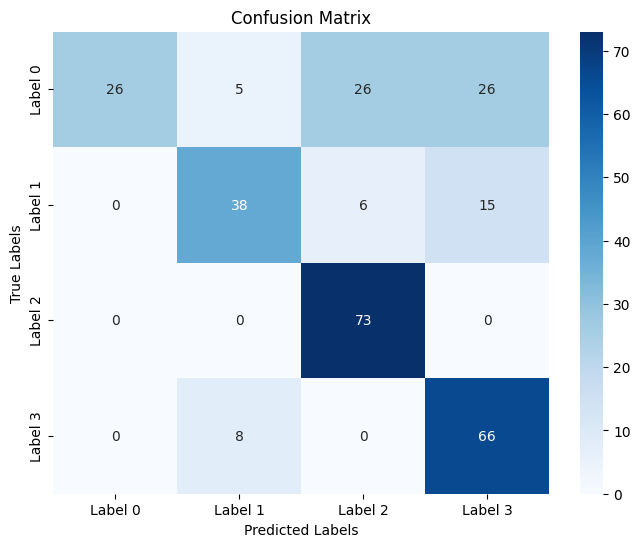

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# 예시 Confusion Matrix

# 클래스 레이블
class_labels = ['Label 0', 'Label 1', 'Label 2', "Label 3"]

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
t1 = pd.read_csv("/content/drive/MyDrive/data/test_kaggle.csv")

  0%|          | 0/249 [00:00<?, ?it/s]

tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2], device='cuda:0')
tensor([2, 2

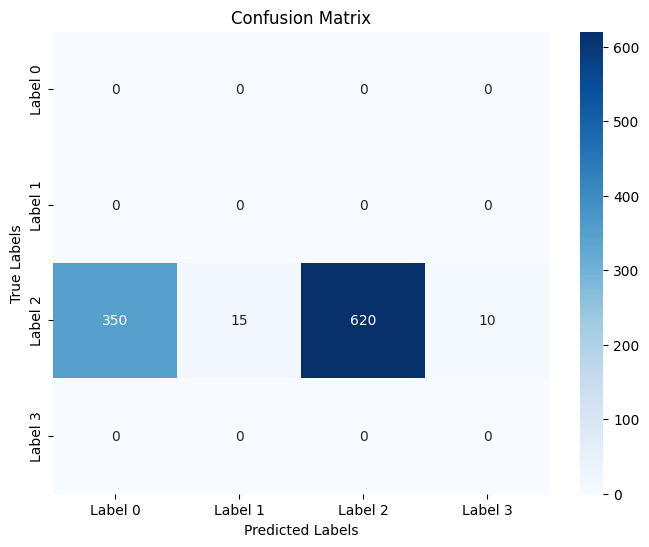

In [ ]:
t1_dataset = CustomDataset(t1["video_name"].values, t1["tag"].values)
t1_loader = DataLoader(t1_dataset, batch_size =4, shuffle=False, num_workers=0)

criterion = nn.CrossEntropyLoss().to(device)
_t1_loss, _t1_score,  label_accuracies, confusion_mat = test_(model, criterion, t1_loader, device)

print("Loss 및 f1 score 보기")
print(f'Test Loss : [{_t1_loss:.5f}] test F1 : [{_t1_score:.5f}]')

print("라벨의 정확성 보기")
print("label_accuracies : ", label_accuracies)


import matplotlib.pyplot as plt
import seaborn as sns

# 예시 Confusion Matrix

# 클래스 레이블
class_labels = ['Label 0', 'Label 1', 'Label 2', "Label 3"]

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
len(t1)

995

In [ ]:
620/995

0.6231155778894473

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/test1.pt")